# End To End Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file using Runway v0.7.0

In [2]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, LLM, PyIngest, UserInput
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Load and Describe Data

The USER_GENERATED_INPUT variable contains a general discription and feature descriptions for each feature we'd like to use in our graph.

In [3]:
USER_GENERATED_INPUT = UserInput(general_description='This is data on different countries.',
                                 column_descriptions={
                                     'id': 'unique id for a country.',
                                    'name': 'the country name.',
                                    'phone_code': 'country area code.',
                                    'capital': 'the capital of the country.',
                                    'currency_name': "name of the country's currency.",
                                    'region': 'primary region of the country.',
                                    'subregion': 'subregion location of the country.',
                                    'timezones': 'timezones contained within the country borders.',
                                    'latitude': 'the latitude coordinate of the country center.',
                                    'longitude': 'the longitude coordinate of the country center.'
                                    }   
                                )

In [4]:
data = pd.read_csv("data/csv/countries.csv")

In [5]:
data.head()

,id,name,iso3,iso2,numeric_code,phone_code,capital,currency,currency_name,currency_symbol,tld,native,region,subregion,timezones,latitude,longitude,emoji,emojiU
0,1,Afghanistan,AFG,AF,4,93,Kabul,AFN,Afghan afghani,؋,.af,افغانستان,Asia,Southern Asia,"[{zoneName:'Asia\/Kabul',gmtOffset:16200,gmtOf...",33.000000,65.0,🇦🇫,U+1F1E6 U+1F1EB
1,2,Aland Islands,ALA,AX,248,+358-18,Mariehamn,EUR,Euro,€,.ax,Åland,Europe,Northern Europe,"[{zoneName:'Europe\/Mariehamn',gmtOffset:7200,...",60.116667,19.9,🇦🇽,U+1F1E6 U+1F1FD
2,3,Albania,ALB,AL,8,355,Tirana,ALL,Albanian lek,Lek,.al,Shqipëria,Europe,Southern Europe,"[{zoneName:'Europe\/Tirane',gmtOffset:3600,gmt...",41.000000,20.0,🇦🇱,U+1F1E6 U+1F1F1
3,4,Algeria,DZA,DZ,12,213,Algiers,DZD,Algerian dinar,دج,.dz,الجزائر,Africa,Northern Africa,"[{zoneName:'Africa\/Algiers',gmtOffset:3600,gm...",28.000000,3.0,🇩🇿,U+1F1E9 U+1F1FF
4,5,American Samoa,ASM,AS,16,+1-684,Pago Pago,USD,US Dollar,$,.as,American Samoa,Oceania,Polynesia,"[{zoneName:'Pacific\/Pago_Pago',gmtOffset:-396...",-14.333333,-170.0,🇦🇸,U+1F1E6 U+1F1F8


## Initialize LLM

We now initialize the LLM to use in data discovery and data model creation.

In [6]:
llm = LLM(model='gpt-4o-2024-05-13')

## Discovery

We now load the above data into a Discovery object.

In [7]:
disc = Discovery(llm=llm, user_input=USER_GENERATED_INPUT, data=data)

In [8]:
disc.run(show_result=True, notebook=True)

Based on the provided summary and description of the data, here is a preliminary analysis:

### Overall Details

1. **Data Completeness**:
   - The dataset contains 250 entries (countries).
   - Most columns are complete, but there are some missing values in the `capital`, `region`, and `subregion` columns.
     - `capital`: 245 non-null (5 missing)
     - `region`: 248 non-null (2 missing)
     - `subregion`: 247 non-null (3 missing)

2. **Data Types**:
   - The dataset includes a mix of data types:
     - Numerical: `id`, `latitude`, `longitude`
     - Categorical: `name`, `phone_code`, `capital`, `currency_name`, `region`, `subregion`, `timezones`

3. **Unique Values**:
   - `name` (country names) and `id` are unique for each entry.
   - `phone_code` has 235 unique values, indicating some countries share the same phone code.
   - `capital` has 244 unique values, with "Kingston" appearing twice.
   - `currency_name` has 161 unique values, with "Euro" being the most frequent (35 occurrences).
   - `region` has 6 unique values, with "Africa" being the most frequent (60 occurrences).
   - `subregion` has 22 unique values, with "Caribbean" being the most frequent (28 occurrences).
   - `timezones` has 245 unique values, with the most frequent timezone appearing 3 times.

### Important Features

1. **Geographical Coordinates**:
   - `latitude` and `longitude` provide the geographical center of each country. These are crucial for spatial analysis and mapping.

2. **Country Identifiers**:
   - `id` and `name` uniquely identify each country. These are essential for referencing and linking data.

3. **Phone Code**:
   - `phone_code` is important for telecommunications and can be used to analyze regional calling patterns.

4. **Capital**:
   - `capital` provides the primary city of governance, which is often a focal point for political and economic activities.

5. **Currency**:
   - `currency_name` is vital for economic analysis, especially in understanding trade and financial systems.

6. **Region and Subregion**:
   - `region` and `subregion` help in categorizing countries into broader geographical and cultural areas. This is useful for regional analysis and comparisons.

7. **Timezones**:
   - `timezones` indicate the time zones within a country, which is important for understanding time-related data and scheduling.

### Summary

- The dataset is relatively complete with a few missing values in `capital`, `region`, and `subregion`.
- The data types are appropriate for the features, with a mix of numerical and categorical data.
- Key features for analysis include geographical coordinates (`latitude`, `longitude`), country identifiers (`id`, `name`), and categorical attributes like `phone_code`, `capital`, `currency_name`, `region`, `subregion`, and `timezones`.
- The dataset provides a comprehensive overview of countries, which can be used for various types of analysis, including geographical, economic, and regional studies.

This preliminary analysis sets the stage for further exploration and potential modeling, including the creation of a graph data model.

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [9]:
gdm = GraphDataModeler(
    llm=llm,
    discovery=disc
)

We now generate our first pass data model.

In [13]:
gdm.create_initial_model()

recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=True), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Capital', properties=[Property(name='name', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=True, part_of_key=True)], csv_name=''), Node(label='Currency', properties=[Property(name='name', type='str', csv_mapping='currency_name', csv_mapping_other=None, is_unique=True, part_of_key=True)], csv_name=''), Node(label='Region', properties=[Property(name='name', type='str', csv_mapping='region', csv_mapping_other=None, is_uniqu

In [14]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=True), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Capital', properties=[Property(name='name', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=True, part_of_key=True)], csv_name=''), Node(label='Currency', properties=[Property(name='name', type='str', csv_mapping='currency_name', csv_mapping_other=None, is_unique=True, part_of_key=True)], csv_name=''), Node(label='Region', properties=[Property(name='name', type='str', csv_mapping='region', csv_mapping_other=None, is_uniqu

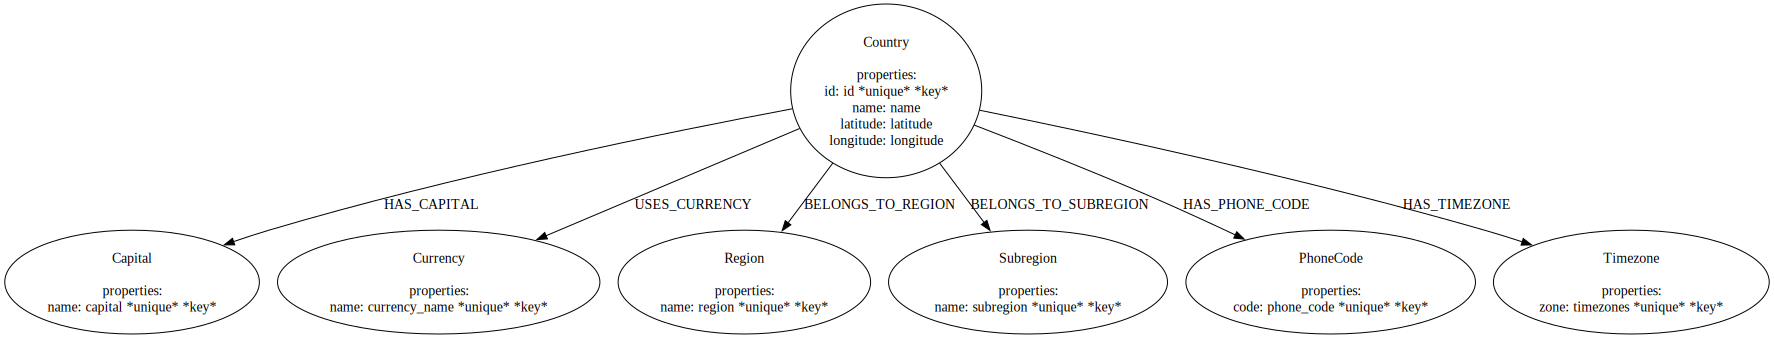

In [15]:
gdm.current_model.visualize()

This doesn't look quite right, so let's prompt the LLM to make some corrections.

In [22]:
gdm.iterate_model(user_corrections="""Make Region node have a HAS_SUBREGION relationship with Subregion node. 
                  Remove The relationship between Country and Region.
                  Set key = False for all properties.""")

recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Capital', properties=[Property(name='name', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Currency', properties=[Property(name='name', type='str', csv_mapping='currency_name', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='name', type='str', csv_mapping='region', csv_mapping_other=None, is_un

In [23]:
gdm.current_model

DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', csv_mapping='id', csv_mapping_other=None, is_unique=True, part_of_key=False), Property(name='name', type='str', csv_mapping='name', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', csv_mapping='latitude', csv_mapping_other=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', csv_mapping='longitude', csv_mapping_other=None, is_unique=False, part_of_key=False)], csv_name=''), Node(label='Capital', properties=[Property(name='name', type='str', csv_mapping='capital', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Currency', properties=[Property(name='name', type='str', csv_mapping='currency_name', csv_mapping_other=None, is_unique=True, part_of_key=False)], csv_name=''), Node(label='Region', properties=[Property(name='name', type='str', csv_mapping='region', csv_mapping_other=None, is_un

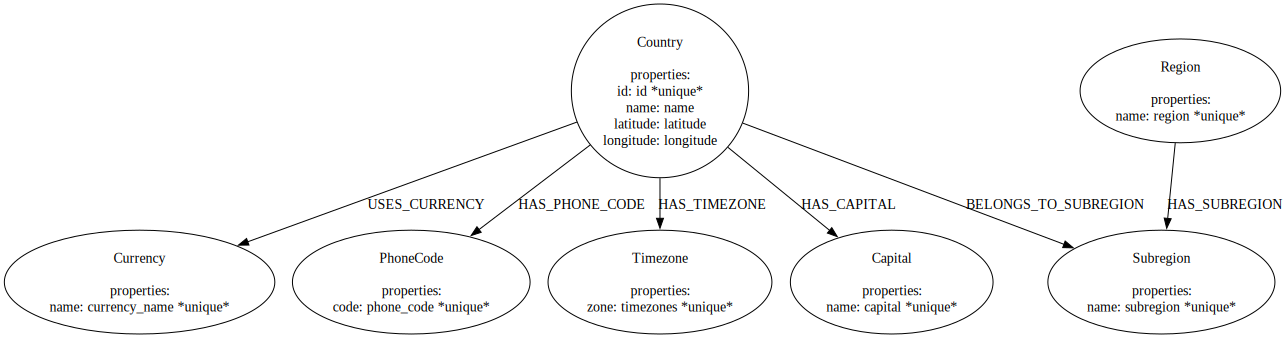

In [24]:
gdm.current_model.visualize()

This is good enough for our demo. We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We can provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [25]:

gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         file_directory="data/csv/", csv_name="countries.csv")

In [26]:
pyingest_yaml = gen.generate_config_string()
# gen.generate_pyingest_yaml_file(file_name="countries")
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT capital_name IF NOT EXISTS FOR (n:Capital) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT currency_name IF NOT EXISTS FOR (n:Currency) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT region_name IF NOT EXISTS FOR (n:Region) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT subregion_name IF NOT EXISTS FOR (n:Subregion) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT phonecode_code IF NOT EXISTS FOR (n:PhoneCode) REQUIRE n.code IS UNIQUE;
  - CREATE CONSTRAINT timezone_zone IF NOT EXISTS FOR (n:Timezone) REQUIRE n.zone IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {id: toIntegerOrNull(row.id)})
    SET n.name = row.name, n.latitude = toFloatOrNull(row.latitude), n.longitude = toFloatOrNull(row.lon

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. First let's confirm our connection though.

In [27]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [28]:
PyIngest(yaml_string=pyingest_yaml, dataframe=data)

/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/neo4j_runway/ingestion/pyingest.py:161: UserWarning: the yaml_string parameter will be depreciated in future releases. Please use the 'config' to identify the YAML file instead.
  warnings.warn(


File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:25.710875
loading... 1 2024-07-25 10:27:25.831961
{} : Completed file 2024-07-25 10:27:25.874371
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:25.874948


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-07-25 10:27:25.920787
{} : Completed file 2024-07-25 10:27:25.947479
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:25.947894
loading... 1 2024-07-25 10:27:26.000605
{} : Completed file 2024-07-25 10:27:26.026412
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.027022
loading... 1 2024-07-25 10:27:26.066024
{} : Completed file 2024-07-25 10:27:26.087253
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.087689
loading... 1 2024-07-25 10:27:26.139537


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


{} : Completed file 2024-07-25 10:27:26.152920
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.153506
loading... 1 2024-07-25 10:27:26.194226
{} : Completed file 2024-07-25 10:27:26.217579
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.217974
loading... 1 2024-07-25 10:27:26.258016
{} : Completed file 2024-07-25 10:27:26.281699
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.282296
loading... 1 2024-07-25 10:27:26.349784


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


{} : Completed file 2024-07-25 10:27:26.376528
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.376950
loading... 1 2024-07-25 10:27:26.435613
{} : Completed file 2024-07-25 10:27:26.459099
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.459632
loading... 1 2024-07-25 10:27:26.514643
{} : Completed file 2024-07-25 10:27:26.535583
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.536075


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


loading... 1 2024-07-25 10:27:26.588542
{} : Completed file 2024-07-25 10:27:26.610934
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.611535
loading... 1 2024-07-25 10:27:26.663684
{} : Completed file 2024-07-25 10:27:26.687132
File {} .//data/csv/countries.csv
loading... 0 2024-07-25 10:27:26.687787
loading... 1 2024-07-25 10:27:26.738352
{} : Completed file 2024-07-25 10:27:26.751575


/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/alexandergilmore/Documents/projects/neo4j-runway-examples/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-graph-0.7.0.png](./images/countries-graph-0.7.0.png)